# <center> Предсказание победителя в Dota 2: Отчёт по домащнему заданию курса ML в институте иоинформатики. 

Код, ответственный за улучшение модели, находится внизу ноутбука: 
[Улучшения модели относительно baseline](#Улучшения-модели-относительно-baseline)


Лучший скор на kaggle: 0.81580

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [2]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [3]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [4]:
PATH_TO_DATA = "."

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [5]:
df_train_features.shape

(31698, 245)

In [6]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [7]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [8]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

Wall time: 2.42 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [11]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [12]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [13]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


Мы также можем увеличить количество деревьев в лесу и глубину дерева (вроде этим сложно испортить модель, только увеличить время)

In [15]:
%%time
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части с 1000 деревьев:", valid_score)
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части с 1000 деревьев:", valid_accuracy)

ROC-AUC score на отложенной части с 1000 деревьев: 0.7890514485881335
Accuracy score (p > 0.5) на отложенной части с 1000 деревьев: 0.7067297581493165
Wall time: 15.6 s


ROC-AUC вырос с 0.7754 до 0.7890 - уже лучше, чем ничего! 

## <left>Посылка

In [16]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [17]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_19-54-45.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [18]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

Я сразу использую больше деревьев в лесу, чтобы получить чуточку лучший результат

In [19]:
%%time
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

Wall time: 1min 29s


In [23]:
cv_scores_rf

array([0.78905145, 0.79081801, 0.78149819, 0.78693214, 0.78951986])

In [24]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7875639297494219


Среднее значение примерно такое же, как и в одном лесу -  0.787. 

## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [25]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [28]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [62]:
for player in  match["players"][:3]: 
    print (player, '\n', '\n', '\n')

{'player_slot': 0, 'hero_id': 31, 'hero_name': 'npc_dota_hero_lich', 'account_id_hash': '1c2500195e6ab646fc9371344724aa77', 'ability_upgrades': [{'ability': 5136, 'time': 358, 'level': 1}, {'ability': 5134, 'time': 437, 'level': 2}, {'ability': 5136, 'time': 511, 'level': 3}, {'ability': 5134, 'time': 578, 'level': 4}, {'ability': 5134, 'time': 637, 'level': 5}, {'ability': 5137, 'time': 713, 'level': 6}, {'ability': 5135, 'time': 764, 'level': 7}, {'ability': 5134, 'time': 839, 'level': 8}, {'ability': 5136, 'time': 912, 'level': 9}, {'ability': 6034, 'time': 981, 'level': 10}, {'ability': 5136, 'time': 1038, 'level': 11}, {'ability': 5137, 'time': 1106, 'level': 12}, {'ability': 5135, 'time': 1185, 'level': 13}, {'ability': 5135, 'time': 1417, 'level': 14}, {'ability': 5135, 'time': 1689, 'level': 15}, {'ability': 6112, 'time': 1875, 'level': 16}], 'obs_placed': 1, 'sen_placed': 0, 'creeps_stacked': 0, 'camps_stacked': 0, 'rune_pickups': 3, 'firstblood_claimed': 0, 'teamfight_partici

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [21]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

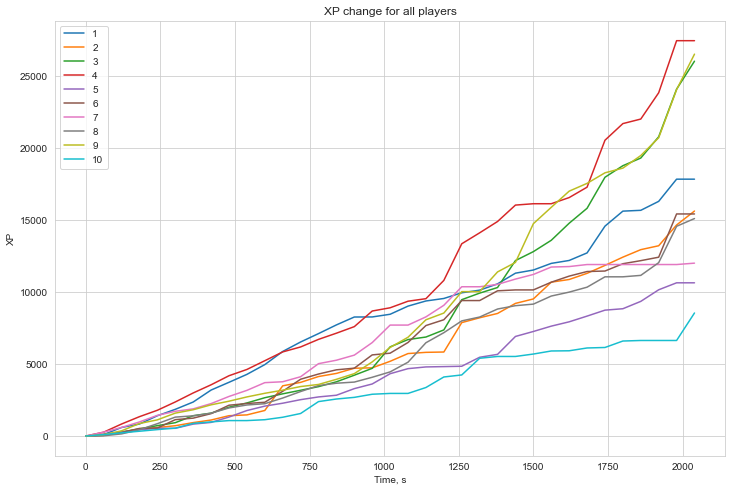

In [29]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [31]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [32]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [33]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

In [34]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [35]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

Wall time: 2min 41s


In [36]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7875639297494219
ROC-AUC на кросс-валидации для новых признаков: 0.7922544268237252


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков (ROC-AUC 0.7922544268237252). A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Улучшения модели относительно baseline

In [ ]:


log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, df_train_features_extended.values, y, cv=cv)
print(f"ROC-AUC на кросс-валидации для логистической регрессии: {score.mean()}")

Это ниже, чем для случайного леса! :( Из тех моделей, что мы знаем, можно ещё попробовать knn 

In [66]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
score = cross_val_score(knn_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для knn: {score.mean()}")

ROC-AUC на кросс-валидации для knn: 0.7094260375452726


Nope. Стало ещё хуже. 

На лекции с ансамблями мы разобирали, что комбинация нескольких методов работает лучше, чем один метод. Можно попробовать взять несколько известных методов и их скомбинировать! 

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
knn_clf = KNeighborsClassifier()


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf)],
    voting='hard')

cv_scores_extended_voting = cross_val_score(voting_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

In [51]:
print(f"ROC-AUC на кросс-валидации для класиификатора-голосовалки: {cv_scores_extended_voting.mean()}")

ROC-AUC на кросс-валидации для класиификатора-голосовалки: 0.7965299041577569


In [44]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf)],
    voting='soft')

cv_scores_extended_voting_soft = cross_val_score(voting_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)


In [47]:
print(f"ROC-AUC на кросс-валидации для класиификатора-голосовалки при voting='soft': {cv_scores_extended_voting_soft.mean()}")

ROC-AUC на кросс-валидации для класиификатора-голосовалки при voting='soft': 0.7965299041577569


Стало немного лучше - 0.7965 вместо 0.7922!
Пока что голосовалка из трёх предикторов работает лучше всего (хотя по отдельности два из этих предикторов работают довольно плохо)

In [ ]:
Попробуем бустинг:

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(df_train_features_extended.values, y)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [57]:
cv_scores_extended = cross_val_score(ada_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для ada boost: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для ada boost: 0.7893944156911911


Кажется, сделать лучше не очень получилось :( 

In [72]:
xgb_clas = xgboost.XGBClassifier(random_state=42, n_estimators=1000)
cv_scores_xgboost = cross_val_score(xgb_clas, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для xgb_clas: {cv_scores_xgboost.mean()}")

ROC-AUC на кросс-валидации для xgb_clas: 0.7922135268812249


In [73]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf), ('xgb', xgb_clas), ('ada', ada_clf)],
    voting='soft')

cv_scores_voting = cross_val_score(voting_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"ROC-AUC на кросс-валидации для голосовалки с xgboost: {cv_scores_voting.mean()}")

ROC-AUC на кросс-валидации для голосовалки с xgboost: 0.8060004481340677


Запишем новые признаки из baseline solution  в тестовую выборку:

In [76]:
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 'test_raw_data.jsonl')

In [78]:
voting_clf.fit(df_train_features_extended.values, y)

[22:31:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            imp...
                                            n_estimators=500, n_jobs=None,
           

In [79]:
X_test = df_test_features_extended.values
y_test_pred = voting_clf.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_22-41-45.csv


Можно ещё отдельными колонками вставить в таблицу признаков золото на команду и KDA на каждого игрока. 



In [87]:
df_train_features_extended['r_gold'] = df_train_features_extended['r1_gold'] + df_train_features_extended['r2_gold'] + \
     df_train_features_extended['r3_gold'] + df_train_features_extended['r4_gold'] + \
     df_train_features_extended['r5_gold']

df_train_features_extended['d_gold'] = df_train_features_extended['d1_gold'] + df_train_features_extended['d2_gold'] + \
     df_train_features_extended['d3_gold'] + df_train_features_extended['d4_gold'] + \
     df_train_features_extended['d5_gold']

for hero_index in ['r1', 'r2', 'r3', 'r4', 'r5', 'd1', 'd2', 'd3', 'd4', 'd5']: 
    df_train_features_extended[hero_index+'_kda'] = (df_train_features_extended[hero_index+'_kills']+df_train_features_extended[hero_index+'_assists'])+0.001/(df_train_features_extended[hero_index+'_deaths']+0.001)

df_train_features_extended['rkda'] = df_train_features_extended['r1_kda']+df_train_features_extended['r2_kda']+df_train_features_extended['r3_kda']+df_train_features_extended['r4_kda']+df_train_features_extended['r5_kda']
df_train_features_extended['dkda'] = df_train_features_extended['d1_kda']+df_train_features_extended['d2_kda']+df_train_features_extended['d3_kda']+df_train_features_extended['d4_kda']+df_train_features_extended['d5_kda']  
    
df_train_features_extended['gold_difference'] = df_train_features_extended['r_gold'] - df_train_features_extended['d_gold']
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,rkda,dkda
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,5.000999,8.000000,7.000000,1.000500,1.000167,2.000333,2.000333,0.000500,32.002498,6.001833
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,5.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,2.000999,4.000999,4.000500,4.000250,5.000000,7.000500,6.000333,3.000999,21.003031,25.002082
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,4.000999,1.000999,0.000999,6.000999,2.000500,6.000000,2.000999,5.000500,13.004163,21.002998


In [88]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf), ('xgb', xgb_clas), ('ada', ada_clf)],
    voting='soft')

cv_scores_voting = cross_val_score(voting_clf, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"ROC-AUC на кросс-валидации для голосовалки с xgboost: {cv_scores_voting.mean()}")

ROC-AUC на кросс-валидации для голосовалки с xgboost: 0.8099870212710553


In [89]:
df_test_features_extended['r_gold'] = df_test_features_extended['r1_gold'] + df_test_features_extended['r2_gold'] + \
     df_test_features_extended['r3_gold'] + df_test_features_extended['r4_gold'] + \
     df_test_features_extended['r5_gold']

df_test_features_extended['d_gold'] = df_test_features_extended['d1_gold'] + df_test_features_extended['d2_gold'] + \
     df_test_features_extended['d3_gold'] + df_test_features_extended['d4_gold'] + \
     df_test_features_extended['d5_gold']

for hero_index in ['r1', 'r2', 'r3', 'r4', 'r5', 'd1', 'd2', 'd3', 'd4', 'd5']: 
    df_test_features_extended[hero_index+'_kda'] = (df_test_features_extended[hero_index+'_kills']+df_test_features_extended[hero_index+'_assists'])+0.001/(df_test_features_extended[hero_index+'_deaths']+0.001)

df_test_features_extended['rkda'] = df_test_features_extended['r1_kda']+df_test_features_extended['r2_kda']+df_test_features_extended['r3_kda']+df_test_features_extended['r4_kda']+df_test_features_extended['r5_kda']
df_test_features_extended['dkda'] = df_test_features_extended['d1_kda']+df_test_features_extended['d2_kda']+df_test_features_extended['d3_kda']+df_test_features_extended['d4_kda']+df_test_features_extended['d5_kda']  
    
df_test_features_extended['gold_difference'] = df_test_features_extended['r_gold'] - df_test_features_extended['d_gold']
df_test_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,rkda,dkda,gold_difference
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,1.000000,1.000000,2.0000,1.000000,1.000000,2.000000,1.000000,4.000999,7.000000,-1911
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3.000999,2.000000,1.0000,1.000333,1.000999,0.000500,0.000999,17.001998,3.002831,2047
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,3.000000,1.000500,2.0000,2.000000,2.000000,2.000999,1.000999,7.002498,9.001998,-1098
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,3.000999,2.000999,7.0002,4.000999,4.000999,6.000000,1.000500,12.003497,22.002698,928
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,5.000999,3.000500,1.0000,1.000999,0.000333,2.000500,3.000333,18.002498,7.002165,1348


In [90]:
voting_clf.fit(df_train_features_extended.values, y)

[23:33:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=42)),
                             ('knn', KNeighborsClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            enable_categorical=False,
                                            gamma=None, gpu_id=None,
                                            imp...
                                            n_estimators=1000, n_jobs=None,
          

In [91]:
X_test = df_test_features_extended.values
y_test_pred = voting_clf.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-04-03_23-36-56.csv


(Спойлер: почему-то в таком виде предсказание не работает - видимо, не совпадает порядок столбцов в тестовых и тренировочных данных)